# Gridplot notebook

This notebook is used to create visualization grids for examining effects of the regularization parameters with different noise levels. As in the other notebooks, we initiate the problem and visualize the choices of $c$ first.

In [1]:
import sys

sys.path.append("../")
import numpy as np
from src.ITRC import ITRC
import src.simulation as simulation
import matplotlib.pyplot as plt

In [11]:
# Parameters of forward problem
L = 2.5
n_x = 200
dt = 0.01
solver_scale = 5  # The denser forward problem mesh size is scaled using this
T = 2.5

# Parameters of inverse problem
noise_level = 1e-3
CG_maxiter = 20

In [3]:
# From the oprecnn simulation
c1 = np.vectorize(lambda x: 1)

# Wave speed with bump
c2 = np.vectorize(lambda x: 1 + simulation.bump(x, a=0, b=L, radius=L / 4, deg=3))

# Piecewise constant wave speed (not smooth!)
node_vals = [0, L / 5, 2 * L / 5, 3 * L / 5, 4 * L / 5, L]
pieces = [1.5, 3, 0.75, 1, 0.5, 1]


def c3(x):
    ret = np.piecewise(x, simulation.cell_condlist(x, node_vals), pieces)
    return ret


Lambda_orig1, dense_t_mesh1 = simulation.simulate_Lambda(
    c=c1, dt=dt, solver_scale=solver_scale, cmax=1
)
Lambda_orig2, dense_t_mesh2 = simulation.simulate_Lambda(
    c=c2, dt=dt, solver_scale=solver_scale, cmax=2
)
Lambda_orig3, dense_t_mesh3 = simulation.simulate_Lambda(
    c=c3, dt=dt, solver_scale=solver_scale, cmax=3
)

In [4]:
# Execute
ITRC1 = ITRC(L, n_x, T, dense_t_mesh1[0::solver_scale], Lambda_orig1)
ITRC2 = ITRC(L, n_x, T, dense_t_mesh2[0::solver_scale], Lambda_orig2)
ITRC3 = ITRC(L, n_x, T, dense_t_mesh3[0::solver_scale], Lambda_orig3)

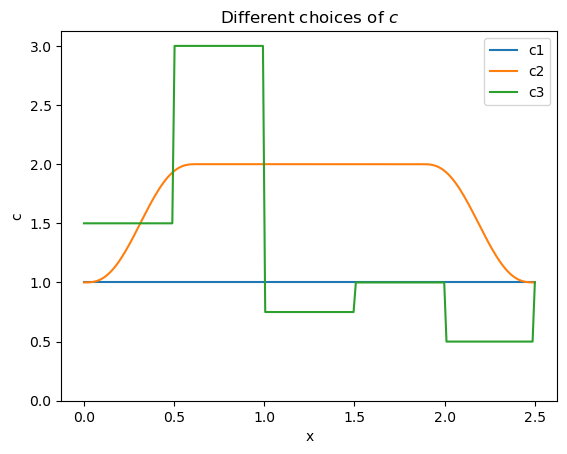

In [5]:
plt.plot(ITRC1.x_mesh, c1(ITRC1.x_mesh), label="c1")
plt.plot(ITRC2.x_mesh, c2(ITRC2.x_mesh), label="c2")
plt.plot(ITRC3.x_mesh, c3(ITRC3.x_mesh), label="c3")
plt.title("Different choices of $c$")
plt.xlabel("x")
plt.ylabel("c")
plt.ylim(bottom=0)
plt.legend()

Next, we perturb each of the maps $\Lambda_i$ with i.i.d. gaussian noise.

In [6]:
import scipy.stats

Lambda_pert1 = Lambda_orig1 + scipy.stats.norm.rvs(
    scale=noise_level, size=ITRC1.Lambda.shape
)
Lambda_pert2 = Lambda_orig2 + scipy.stats.norm.rvs(
    scale=noise_level, size=ITRC2.Lambda.shape
)
Lambda_pert3 = Lambda_orig3 + scipy.stats.norm.rvs(
    scale=noise_level, size=ITRC3.Lambda.shape
)
ITRC1.Lambda = Lambda_pert1
ITRC2.Lambda = Lambda_pert2
ITRC3.Lambda = Lambda_pert3

We then form a grid of volume plots to assess how different values of $\alpha_{\text{Vol}}$ suppress noise. Due to the large number of volume calculations, the following part is computationally demanding.

In [ ]:
from collections import defaultdict

alphas = [1e-4, 1e-3, 1e-2, 1e-1]
sigmas = [1e-4, 1e-3, 1e-2, 1e-1]
Vol_recs = defaultdict(list)
for i in range(len(alphas)):
    for j in range(len(sigmas)):
        alpha_vol = alphas[i]
        sigma = sigmas[j]

        ITRC1.Lambda = Lambda_orig1 + scipy.stats.norm.rvs(
            scale=sigma, size=ITRC1.Lambda.shape
        )
        ITRC2.Lambda = Lambda_orig2 + scipy.stats.norm.rvs(
            scale=sigma, size=ITRC2.Lambda.shape
        )
        ITRC3.Lambda = Lambda_orig3 + scipy.stats.norm.rvs(
            scale=sigma, size=ITRC3.Lambda.shape
        )

        Vol_rec1 = ITRC1.travel_time_volume(
            maxiter=CG_maxiter, alpha_vol=alpha_vol, silent=True
        )
        Vol_rec2 = ITRC2.travel_time_volume(
            maxiter=CG_maxiter, alpha_vol=alpha_vol, silent=True
        )
        Vol_rec3 = ITRC3.travel_time_volume(
            maxiter=CG_maxiter, alpha_vol=alpha_vol, silent=True
        )
        Vol_rec_list = [Vol_rec1, Vol_rec2, Vol_rec3]
        Vol_recs[i].append(Vol_rec_list)

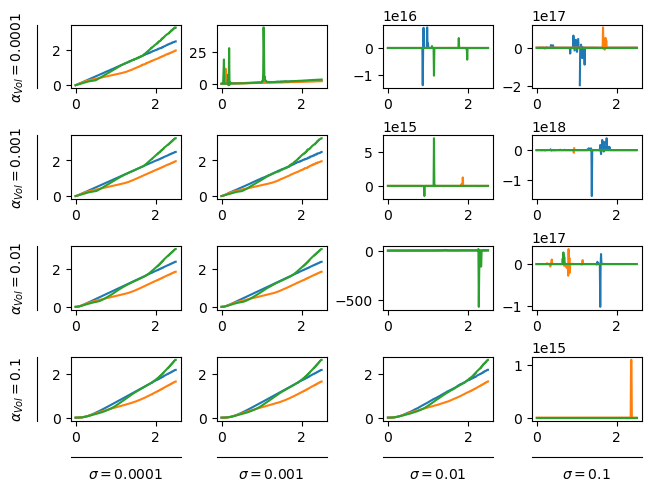

In [15]:
import plot_tools

mesh_argmax = ITRC1.t_mesh[ITRC1.t_mesh <= ITRC1.T].argmax()
t_mesh = ITRC1.t_mesh[: mesh_argmax + 1]

plot_tools.volume_grid(
    Vol_recs=Vol_recs, t_mesh=t_mesh, alpha_vols=alphas, sigmas=sigmas
)

The case $\alpha_{\text{Vol}} = \sigma = 0.01$ is delicate: sometimes the method gives results with moderate noise intact, whereas other times the method completely breaks down.

## Regularizing the numerical derivatives

Next, we generate a grid to compare the effects of the two regularization parameters. Note that the noise level is set at the beginning of the notebook.

In [ ]:
from collections import defaultdict

ITRC1.Lambda = Lambda_pert1
ITRC2.Lambda = Lambda_pert2
ITRC3.Lambda = Lambda_pert3

alpha_vols = np.logspace(-4, -1, 4)
alpha_TVs = np.logspace(-3, 0, 4)
c_recs = defaultdict(list)
for i in range(len(alpha_vols)):
    for j in range(len(alpha_TVs)):
        alpha_vol = alpha_vols[i]
        alpha_TV = alpha_TVs[j]
        c_rec, _, _ = ITRC3.run(
            alpha_vol=alpha_vol,
            alpha_TV=alpha_TV,
            CG_maxiter=CG_maxiter,  # , silent=True
        )
        c_recs[i].append(c_rec)

# NOTE: output removed manually.
# The output includes error messages from divergent TV calls,
# which contain paths.

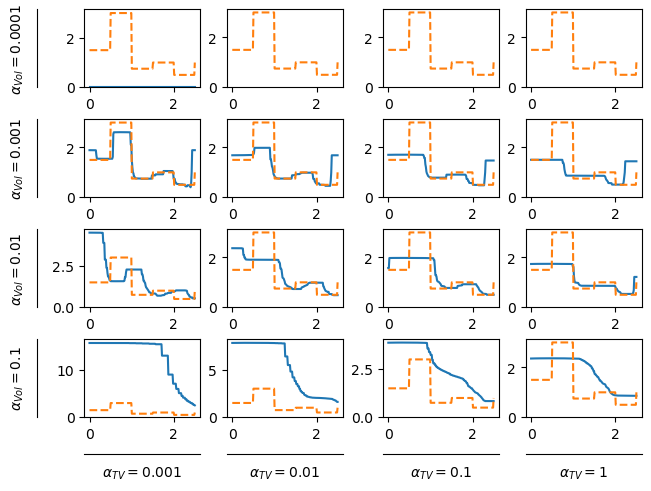

In [13]:
import plot_tools

plot_tools.c_comparison_grid(ITRC3, c_recs, c3, 3, alpha_vols, alpha_TVs)